In [1]:
import networkx as nx
from qiskit import *
import numpy as np
from CSSCodesGottesman import *
from KitaevSurfaceCode import *

import pandas as pd


In this notebook, we give a brief tutorial on the surface code and showcase some of the functionality provided by the [main python module](./src/KitaevSurfaceCode.py) of the repository.

The module [KitaevSurfaceCode.py](./src/KitaevSurfaceCode.py) defines a surface code class, whose objects represent ``surface codes": one can think of these as $k_{0} \times k_{1}$ planar lattices (with both rough and smooth edges), populated with qubits, forming a quantum system initialized to a given logical state. The logical state of the system is encoded via Kitaev's surface code.  

To initialize a surface code object, one must specify the dimensions of the planar lattice. The logical state that the surface code initializes to is an optional parameter -- without any specification, it is assumed that the surface code is initialized to the ground state / logical $0$ state. The optional parameter "p_error" indicates the error probability for a depolarizing channel which is applied to all the physical qubits, after the initial logical state has been initialized.

In [40]:
surface_code = SurfaceCode(3,5, p_error=0)

Once we initialize the surface code, we can call on NetworkX to visualize the corresponding lattice grid (whose edges are populated by the surface code physical qubits), and Tanner graphs. As a CSS code, the Tanner graphs are bipartite graphs corresponding to $X$ and $X$ checks respectively. From the perspective of the lattice geometry, the $X$ check nodes indicate locations of "stars" and $Z$ check nodes indicate positions of "plaquettes". 

Here is the primary lattice grid of the $5 \times 5$ surface code: 

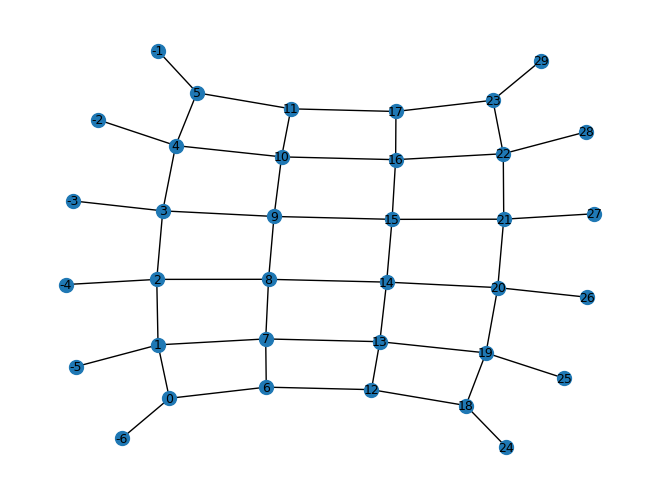

In [41]:
nx.draw( surface_code.lattice_grid, pos=nx.spring_layout( surface_code.lattice_grid, iterations=1000) , node_size = 100, font_size = 9, with_labels=True )

Here are the corresponding X and Z Tanner graphs, respectively:

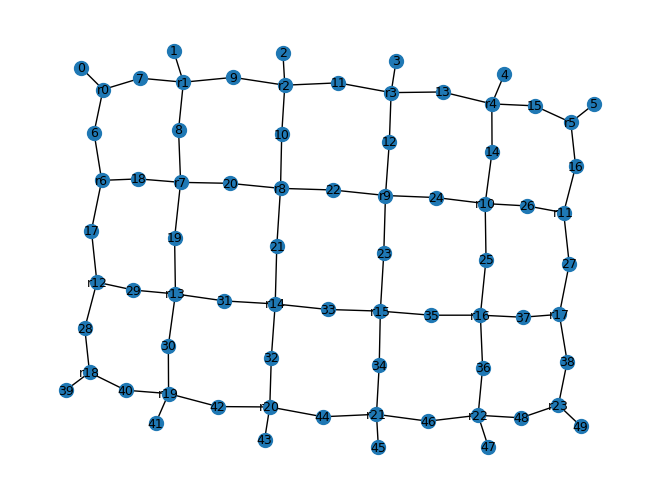

In [42]:
nx.draw( surface_code.X_graph, pos=nx.spring_layout( surface_code.X_graph, iterations=1000) , node_size = 100, font_size = 9, with_labels=True )

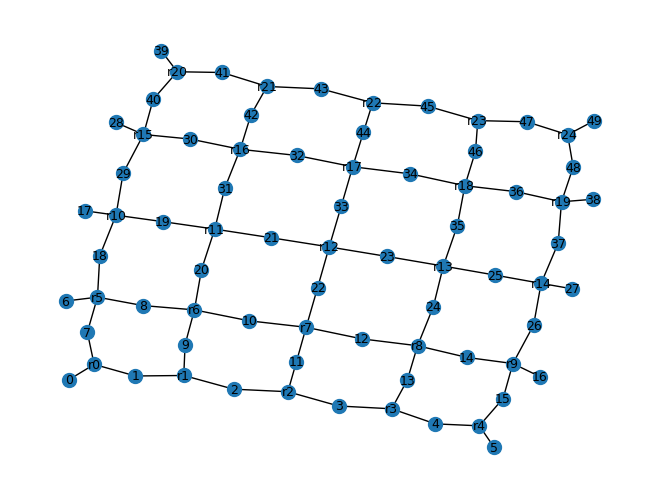

In [43]:
nx.draw( surface_code.Z_graph, pos=nx.spring_layout( surface_code.Z_graph, iterations=1000) , node_size = 100, font_size = 9, with_labels=True )

As we can see, in both graphs, check nodes are labelled by strings of the form 'r' + index (where index corresponds to the index of the star or plaquette with respect to an ordering of the stars or plaquettes). The nodes with integer labels correspond to the qubits of the surface code, the qubits are labelled via an ordering of the edges of the primary lattice. The check nodes connect to the qubit nodes if the edge containing corresponding qubit is contained in the corresponding star or plaquette.

We initialized the surface code with no error, but we can manually put the surface code system through a depolarizing channel with a given error rate. 

In [44]:
ApplyPauliError(surface_code.LatticeCircuit, surface_code.DataQubits, 0.07)

Then, we can run the surface code through a syndrome measurement cycle, by calling a method:

In [45]:
surface_code.syndrome_cycle()

Finally, we can call a method to perform a final Z-parity check for the surface code. It introduces 1 classical measurement bit, which measures the Z-parity of the physical qubits. If the initialized logical state was the ground state, this classical bit should measure $0$ in the end. 

In [46]:
surface_code.measure_data()

In [47]:
job = AerSimulator().run(surface_code.LatticeCircuit, shots=1, memory=True)
result = job.result()
memory = result.get_memory(surface_code.LatticeCircuit)
memory_result = memory[0].replace(' ','')[::-1]

print(memory_result[-1])

0


The last bit in the classical register is the outcome of the final Z-parity measurement. Therefore, the surface code was successful in decoding the physical qubits to logical $0$ if the above read-out is a $0$.

We may use this implementation to give estimates on the code threshold of the surface code. We write a helper function to help record bulk simulations:

In [2]:
def execute_model(x_0,k0,k1 , p_error, num_shots, success=True, report_error=False):
    success_rate = 0
    for i in range(num_shots):
        surface_code = SurfaceCode_single_round(x_0, k0,k1, p_error)
        LatticeCircuit = surface_code.LatticeCircuit
        job = AerSimulator().run(LatticeCircuit, shots=1, memory=True)
        result = job.result()
        memory = result.get_memory(LatticeCircuit)
        memory_result = memory[0].replace(' ','')[::-1]
        if report_error:
            print(memory_result)
        if memory_result[-1] == str(x_0):
            success_rate += 1     
            
    if success == True:      
        return  success_rate/num_shots
    
    if success == False:
        return 1 - (success_rate/num_shots) 

After running some local simulations, with six different code distances ($d =  3,5,7,9,11,13$), at $2000$ shots per sampled physical error rate ($10$ samples taken from a range from 8% to 18%), we can see that the code threshold for the planar surface code is at around 15%, similar to the code threshold for the toric code. 

Done testing 5x5  lattice.. 
Done testing 7x7  lattice.. 
Done testing 9x9 lattice.. 
Done testing 11x11 lattice.. 
Done testing 13x13  lattice.. 


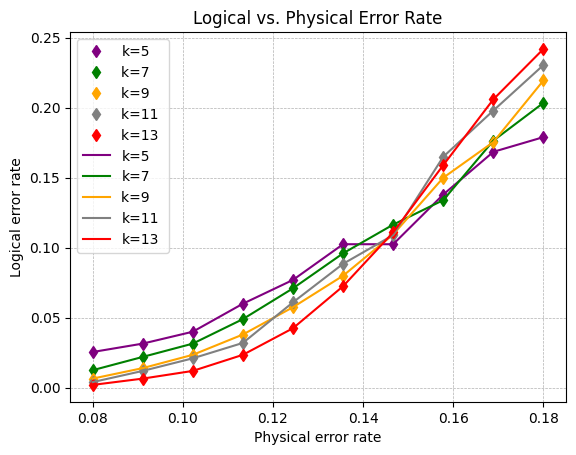

/tmp/ipykernel_111726/3929743075.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


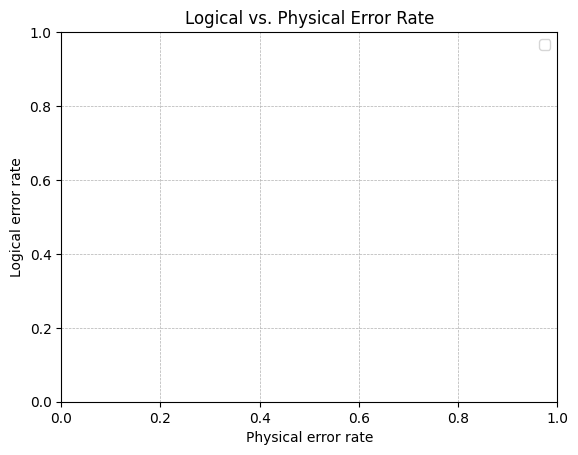

In [ ]:
x_0 = 0

error_rates = np.linspace(0.08, 0.18, 10)


logical_error_rates_5x5 = [execute_model(x_0,  3, 5, p, 2000, success=False) for p in error_rates]
print( 'Done testing 5x5  lattice.. ')
logical_error_rates_7x7 = [execute_model(x_0,  5, 7, p, 2000, success=False) for p in error_rates]
print( 'Done testing 7x7  lattice.. ')
logical_error_rates_9x9 = [execute_model(x_0,  7, 9, p, 2000, success=False) for p in error_rates]
print( 'Done testing 9x9 lattice.. ')
logical_error_rates_11x11 = [execute_model(x_0, 9, 11, p, 2000, success=False) for p in error_rates]
print( 'Done testing 11x11 lattice.. ')
logical_error_rates_13x13 = [execute_model(x_0,  11,13 , p, 2000, success=False) for p in error_rates]
print( 'Done testing 13x13  lattice.. ')

plt.plot(error_rates, logical_error_rates_5x5, 'd', color='purple', label='k=5')
plt.plot(error_rates, logical_error_rates_7x7, 'd', color='green', label='k=7 ')
plt.plot(error_rates, logical_error_rates_9x9, 'd', color='orange', label='k=9 ')
plt.plot(error_rates, logical_error_rates_11x11, 'd', color='grey', label='k=11 ')
plt.plot(error_rates, logical_error_rates_13x13, 'd', color='red', label='k=13 ')

# plt.plot(error_rates, logical_error_rates_3x3,  color='blue', label='k=3')
plt.plot(error_rates, logical_error_rates_5x5,  color='purple', label='k=5')
plt.plot(error_rates, logical_error_rates_7x7, color='green', label='k=7')
plt.plot(error_rates, logical_error_rates_9x9,  color='orange', label='k=9 ')
plt.plot(error_rates, logical_error_rates_11x11, color='grey', label='k=11')
plt.plot(error_rates, logical_error_rates_13x13, color='red', label='k=13')


plt.title('Logical vs. Physical Error Rate')
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()




In [38]:

logical_error_rates_3x3 = [execute_model(x_0,  1, 3, p, 2000, success=False) for p in error_rates]
print( 'Done testing 3x3 lattice.. ')

Done testing 3x3 lattice.. 


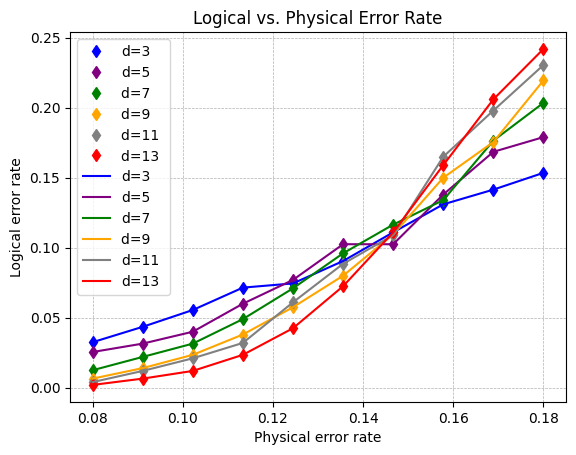

In [3]:
plt.plot(error_rates, logical_error_rates_3x3, 'd', color='blue', label='d=3')
plt.plot(error_rates, logical_error_rates_5x5, 'd', color='purple', label='d=5')
plt.plot(error_rates, logical_error_rates_7x7, 'd', color='green', label='d=7 ')
plt.plot(error_rates, logical_error_rates_9x9, 'd', color='orange', label='d=9 ')
plt.plot(error_rates, logical_error_rates_11x11, 'd', color='grey', label='d=11 ')
plt.plot(error_rates, logical_error_rates_13x13, 'd', color='red', label='d=13 ')


plt.plot(error_rates, logical_error_rates_3x3,  color='blue', label='d=3')
plt.plot(error_rates, logical_error_rates_5x5,  color='purple', label='d=5')
plt.plot(error_rates, logical_error_rates_7x7, color='green', label='d=7')
plt.plot(error_rates, logical_error_rates_9x9,  color='orange', label='d=9 ')
plt.plot(error_rates, logical_error_rates_11x11, color='grey', label='d=11')
plt.plot(error_rates, logical_error_rates_13x13, color='red', label='d=13')


plt.title('Logical vs. Physical Error Rate')
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

